Importing libraries

In [4]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
from pycaret.regression import *



We have prepared a list instruments for which we need to import data. yahoofinancials package requires Yahoo ticker symbols. The list contains the ticker symbols and their descriptions. We import that file and extract the tciker symbols and the names as seprarate lists

In [5]:
ticker_details = pd.read_excel("Ticker List.xlsx")
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()
ticker_details.head(20)

,Ticker,Description
0,GC=F,Gold
1,SI=F,Silver
2,CL=F,Crude Oil
3,^GSPC,S&P500
4,PL=F,Platinum
5,HG=F,Copper
6,DX=F,Dollar Index
7,^VIX,Volatility Index
8,EEM,MSCI EM ETF
9,EURUSD=X,Euro USD


Once we have the list, we need to define what date range we need to import the data for. The period we have chosen is Jan 2010 till 1st Mar 2020. The reason we did not pull data prior to that is because the Global Financial Crisis (GFC) in 2008–09 massively changed the economic and market landscapes. Relationships prior to that period might be of less relevance now.

We create a date-range and write it to an empty dataframe named values where we would extract and paste data we pull from yahoofinancials.

In [6]:
#Preparing Date Range
end_date= datetime.strftime(datetime.today(),'%Y-%m-%d')
start_date = "2020-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])


In [7]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
    df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    df.columns = ['Date1',i]
    df['Date1']= pd.to_datetime(df['Date1'])
    values = values.merge(df,how='left',left_on='Date',right_on='Date1')
    values = values.drop(labels='Date1',axis=1)


In [8]:
#Renaming columns to represent instrument names rather than their ticker codes for ease of readability
names.insert(0,'Date')
values.columns = names
#Front filling the NaN values in the data set
values = values.fillna(method="ffill",axis=0)
values = values.fillna(method="bfill",axis=0)
# Co-ercing numeric type to all columns except Date
cols=values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=1)
imp = ['Gold','Silver', 'Crude Oil', 'S&P500','MSCI EM ETF']

In [9]:
# Calculating Short term -Historical Returns
change_days = [1,3,5,14,21]
data = pd.DataFrame(data=values['Date'])
for i in change_days:
    x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
# Calculating Long term Historical Returns
change_days = [60,90,180,250]
for i in change_days:
    x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]


In [10]:
#Calculating Moving averages for Gold
moving_avg = pd.DataFrame(values['Date'],columns=['Date'])
moving_avg['Date']=pd.to_datetime(moving_avg['Date'],format='%Y-%b-%d')
moving_avg['Gold/15SMA'] = (values['Gold']/(values['Gold'].rolling(window=15).mean()))-1
moving_avg['Gold/30SMA'] = (values['Gold']/(values['Gold'].rolling(window=30).mean()))-1
moving_avg['Gold/60SMA'] = (values['Gold']/(values['Gold'].rolling(window=60).mean()))-1
moving_avg['Gold/90SMA'] = (values['Gold']/(values['Gold'].rolling(window=90).mean()))-1
moving_avg['Gold/180SMA'] = (values['Gold']/(values['Gold'].rolling(window=180).mean()))-1
moving_avg['Gold/90EMA'] = (values['Gold']/(values['Gold'].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
moving_avg['Gold/180EMA'] = (values['Gold']/(values['Gold'].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
moving_avg = moving_avg.dropna(axis=0)

In [11]:
#Merging Moving Average values to the feature space
data['Date']=pd.to_datetime(data['Date'],format='%Y-%b-%d')
data = pd.merge(left=data,right=moving_avg,how='left',on='Date')
data = data[data['Gold-T-250'].notna()]
prediction_data = data.copy()

In [12]:
#Loading the stored model
regressor_22 = load_model("22Day Regressor");


Transformation Pipeline and Model Successfully Loaded


In [13]:
#Making Predictions
predicted_return_22 = predict_model(regressor_22,data=prediction_data)
predicted_return_22=predicted_return_22[['Date','Label']]
predicted_return_22.columns = ['Date','Return_22']


In [14]:
#Adding return Predictions to Gold Values
predicted_values = values[['Date','Gold']]
predicted_values = predicted_values.tail(len(predicted_return_22))
predicted_values = pd.merge(left=predicted_values,right=predicted_return_22,on=['Date'],how='inner')
predicted_values['Gold-T+22']=(predicted_values['Gold']*(1+predicted_values['Return_22'])).round(decimals =1)


In [15]:
#Adding T+22 Date
from datetime import datetime, timedelta
predicted_values['Date-T+22'] = predicted_values['Date']+timedelta(days = 22)
predicted_values.tail()

,Date,Gold,Return_22,Gold-T+22,Date-T+22
98,2021-05-03,1791.4,-0.002961,1786.1,2021-05-25
99,2021-05-04,1775.8,-0.004972,1767.0,2021-05-26
100,2021-05-05,1784.1,0.000682,1785.3,2021-05-27
101,2021-05-06,1815.5,0.010835,1835.2,2021-05-28
102,2021-05-07,1831.1,0.021760,1870.9,2021-05-29


The table output above shows that closing price of Gold on 3th May 2021 was 1,791.4(Dollars) and the model predicts that in next 22-Days the returns would be -0.23 per cent 
resulting in a price target of 1,786.1(Dollars) by 25th of May 2021

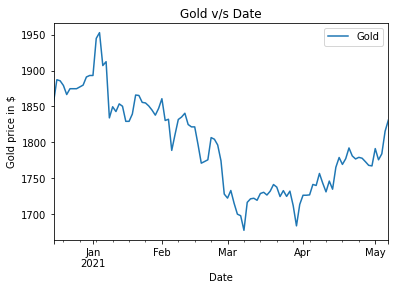

In [34]:
pds=predicted_values.plot(x ='Date', y='Gold',ylabel='Gold price in $',title="Gold v/s Date")


Comparison Graph fro the actual and the predicted price on Gold in $.


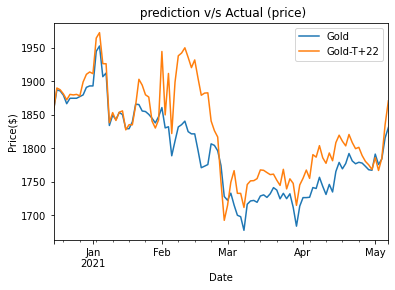

In [33]:
pf=predicted_values.plot(x="Date",y=["Gold","Gold-T+22"],xlabel="Date",ylabel="Price($)",title=" prediction v/s Actual (price)")